# Analysing the pNEUMA dataset
Data from: https://open-traffic.epfl.ch/

***********************************************************************************************************
## References

Emmanouil Barmpounakis, Nikolas Geroliminis,
On the new era of urban traffic monitoring with massive drone data: The pNEUMA large-scale field experiment,
Transportation Research Part C: Emerging Technologies,
Volume 111,
2020,
Pages 50-71,
ISSN 0968-090X,
https://doi.org/10.1016/j.trc.2019.11.023.

Paul Newson and John Krumm. 2009. Hidden Markov map matching through noise and sparseness. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (GIS '09). Association for Computing Machinery, New York, NY, USA, 336–343. DOI:https://doi.org/10.1145/1653771.1653818

Meert, Wannes, and Verbeke, Mathias. HMM with Non-Emitting States for Map Matching. 2018.

Graser, Anita. “MovingPandas: Efficient Structures for Movement Data in Python.” GI_Forum, vol. 1, 2019, pp. 54–68. DOI:https://doi.org/10.1553/giscience2019_01_s54.

Boeing, G. 2017. OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. Computers, Environment and Urban Systems 65, 126-139. DOI:https://doi.org/10.1016/j.compenvurbsys.2017.05.004

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

SOMPY: A Python Library for Self Organizing Map (SOM)
V Moosavi, S Packmann, I Vallés
https://github.com/sevamoo/SOMPY
***********************************************************************************************************

In [1]:
import os
import csv
import glob
import math
import pickle
import traceback
import logging
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import numpy as np
import osmnx as ox
import datetime as dt
import contextily as ctx
import geopandas as gpd
import movingpandas as mpd
import sompylib.sompy as SOM

In [6]:
from geopy import distance
from datetime import timedelta
from geopandas import GeoDataFrame
from ipywidgets import IntSlider, interact 
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [7]:
#from pydmd import DMD

*******************************************

# Load data

In [8]:
def read_csv(path):
    metadata_cols = [
        'track_id',
        'type',
        'traveled_d',
        'avg_speed',
    ]
    data_cols = [
        'lat',
        'lon',
        'speed',
        'lat_acc',
        'lon_acc',
        'time',
        'track_id',
    ]

    metadata_colsize = len(metadata_cols)
    data_colsize = len(data_cols) - 1

    metadata_rows = list()
    data_rows = list()

    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        next(csv_reader)
        metadata = dict()
        for row in csv_reader:
            row = [item.strip() for item in row]
            track_id = int(row[0])
            metadata_rows.append(row[:metadata_colsize])

            data_traj = [
                float(item) for item in row[metadata_colsize:] if len(item) > 0
            ]
            for i in range(0, len(data_traj), data_colsize):
                data_row = data_traj[i:i + data_colsize] + [track_id]
                data_rows.append(data_row)

    data = pd.DataFrame(data_rows, columns=data_cols)
    metadata = pd.DataFrame(metadata_rows, columns=metadata_cols)
    metadata = metadata.set_index('track_id')
    metadata.index = metadata.index.astype(int)
    return metadata, data

In [11]:
files = []
root = os.getcwd()
path = './data/pNEUMA/'
os.chdir(path)
for file in glob.glob("*.csv"):
    files.append(file)
os.chdir(root)
find = -5
urlpath = f'{path}{files[find]}'
print(urlpath)

./data/pNEUMA/20181024_d8_0930_1000.csv


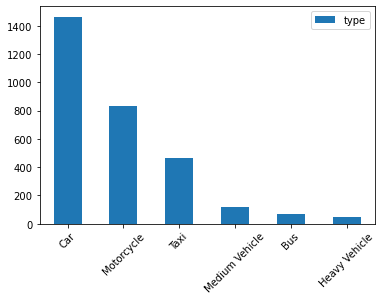

In [8]:
metadata, data = read_csv(urlpath)
ax = metadata.type.value_counts(dropna=False).plot.bar(rot=45, legend=True)

# Extract geometries for visualization

In [10]:
%%time
# Initialize points in ETRS89 reference system.
geometries = gpd.GeoDataFrame(data[['lat', 'lon', 'speed']],
                              geometry=gpd.points_from_xy(
                                  data.lon,
                                  data.lat,
                                  crs={'init': 'epsg:4326'}))
geometries.crs

CPU times: user 2min 59s, sys: 1.73 s, total: 3min 1s
Wall time: 3min 1s


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
%%time
# Convert to Pseudo-Mercator for cartography.
geometries = geometries.to_crs(epsg=3857)
geometries.crs

CPU times: user 4min 28s, sys: 840 ms, total: 4min 29s
Wall time: 4min 29s


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Path for geometries
geometries_dir = f"{path}geometries/"
if not os.path.exists(geometries_dir):
    os.makedirs(geometries_dir)
geometries_url = f'{geometries_dir}{files[find][:-3]}parquet.gzip'
geometries_url

'./data/pNEUMA/geometries/20181024_d8_0930_1000.parquet.gzip'

In [14]:
# Write geometries to file.
geometries.to_parquet(geometries_url, compression='gzip')

In [10]:
# Read geometries from file.
geometries = gpd.read_parquet(geometries_url)

# Create trajectories

In [12]:
# Time entry
year = 2018
month = 10
day = 24
hour = 9
minute = 30

In [23]:
# Merge metadata with data
df = pd.merge(metadata[['type']],
              data,
              left_index=True,
              right_on='track_id')

In [24]:
# Create timestamps
df['timestamp'] = df.apply(
    lambda x: dt.datetime(year, month, day, hour, minute) + timedelta(seconds=x.time),
    axis=1)
df = df.set_index('timestamp')

In [28]:
%%time
# Initialize points in ETRS89 reference system.
geolocations = gpd.GeoDataFrame(df,
                                geometry=gpd.points_from_xy(
                                    df.lon,
                                    df.lat,
                                    crs={'init': 'epsg:4326'}))
geolocations.crs

CPU times: user 2min 51s, sys: 1.54 s, total: 2min 52s
Wall time: 2min 52s


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
%%time
trajectories = []
for key, values in geolocations.groupby(['track_id']):
    try:
        trajectory = mpd.Trajectory(values, key)
        if trajectory.df.shape[0] > 1:
            trajectories.append(trajectory)
    except:
        pass

print("Finished creating {} trajectories".format(len(trajectories)))

Finished creating 3001 trajectories
CPU times: user 4.5 s, sys: 320 ms, total: 4.82 s
Wall time: 4.83 s


In [30]:
%%time
traj_collection = mpd.TrajectoryCollection(trajectories[:])
print(traj_collection)

TrajectoryCollection with 3001 trajectories
CPU times: user 8min 17s, sys: 15.8 ms, total: 8min 17s
Wall time: 8min 17s


In [15]:
# Path for trajectories
collection_dir = f"{path}trajectories/"
if not os.path.exists(collection_dir):
    os.makedirs(collection_dir)
collection_url = f"{collection_dir}{files[find][:-4]}.pickle"
collection_url

'./data/pNEUMA/trajectories/20181024_d8_0930_1000.pickle'

In [ ]:
# Export trajectory collection 
with open(collection_url, 'wb') as f:
    pickle.dump(traj_collection, f)

In [16]:
# Import trajectory collection
with open(collection_url, "rb") as f:
    unpickler = pickle.Unpickler(f)
    traj_collection = unpickler.load()

# Vehicle movement visualization

In [17]:
def get_locations_at_timestamps(col, t):
    pos = []
    for traj in col.trajectories:
        if t >= traj.get_start_time() and t <= traj.get_end_time():
            pos.append({
                'geometry': traj.get_position_at(t),
                'id': str(traj.id),
                'type': traj.df['type'].values[0]
            })
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

In [19]:
# Extract x, y and c from geopandas.
latitude = geometries.geometry.y
longitude = geometries.geometry.x
c = geometries.speed

In [92]:
# Specify maptiles source.
basemap = ctx.providers.CartoDB.DarkMatter

In [24]:
@interact(i=(traj_collection.get_min('time'), traj_collection.get_max('time'),
             0.5))
def plot(i=10):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(longitude, latitude, c=c, s=0.05, ec=None, cmap='plasma')

    t = dt.datetime(year, month, day, hour, minute) + timedelta(seconds=i)
    points = get_locations_at_timestamps(traj_collection, t)
    points = points.to_crs(epsg=3857)
    sizes = {
        'Car': 30,
        'Taxi': 30,
        'Bus': 90,
        'Motorcycle': 5,
        'Medium Vehicle': 50,
        'Heavy Vehicle': 90
    }
    colors = {
        'Car': 'white',
        'Taxi': 'gold',
        'Bus': 'royalblue',
        'Motorcycle': 'crimson',
        'Medium Vehicle': 'saddlebrown',
        'Heavy Vehicle': 'darkgreen'
    }
    points['sizes'] = points['type'].map(sizes)
    points['colors'] = points['type'].map(colors)
    lat_points = points.geometry.y
    lon_points = points.geometry.x
    sizes = points['sizes']
    colors = points['colors']
    ax.scatter(lon_points, lat_points, s=sizes, ec=None, c=colors)
    ax.set_axis_off()
    ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)
    #fig.savefig('alexandras.png', format='png', dpi=300)

interactive(children=(FloatSlider(value=10.0, description='i', max=1061.8, min=2.4, step=0.5), Output()), _dom…

********************************************

# Mapmatching

In [14]:
#traj_collection = valid_traj_collection

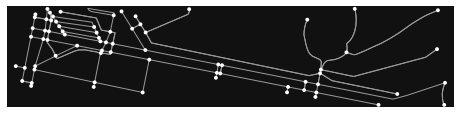

In [15]:
G = ox.graph_from_bbox(traj_collection.get_max('lat')+.0002,
                       traj_collection.get_min('lat')-.0001,
                       traj_collection.get_max('lon')+.0012,
                       traj_collection.get_min('lon')-.001,
                       simplify=True,
                       retain_all=False,
                       truncate_by_edge=False,
                       clean_periphery = False)
ax = ox.plot_graph(G)

In [194]:
def make_map(nodes, edges):
    map_con = InMemMap("myosm",
                       use_latlon=True,
                       use_rtree=True,
                       index_edges=True)
    
    for nid, row in nodes[['y', 'x']].iterrows():
        map_con.add_node(nid, (row['y'], row['x']))
    for nid, row in edges.reset_index()[['u', 'v']].iterrows():
        map_con.add_edge(row['u'], row['v'])

    return map_con

In [195]:
# Get nodes and edges from graph G
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [196]:
#****************************************************************
# Experiment setup and calibration
#****************************************************************
# Get nodes and edges from graph G
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
downstream = edges[(edges.name == 'Αλεξάνδρας')].take(
    [5, 7, 8, 9, 10, 11, 12, 13, 14, 17, 20, 22, 25])
downstream_end = downstream.take([-1]).reset_index()
downstream_start = downstream.take([-4]).reset_index()
upstream = edges[(edges.name == 'Αλεξάνδρας')].take(
    [0, 1, 2, 3, 4, 6, 15, 16, 18, 19, 21, 23, 24, 26])
upstream_start = upstream.take([-2]).reset_index()
upstream_end = upstream.take([-6]).reset_index()
# Specify arterial of interest
arterial = downstream.reset_index()
# Start point of arterial for distance measurement
start = nodes.loc[downstream_start.u.values[0]].geometry
start = (start.y, start.x)
# End point of arterial
end = nodes.loc[downstream_end.v.values[0]].geometry
end = (end.y, end.x)
# Geodesic distance
d = distance.GeodesicDistance(start, end).m
print(f'Geodesic: {d}')
# Ground truth distance
D = arterial['length'].sum()
print(f'True: {D}')
# Error factor
e = D / d

Geodesic: 568.8938791629043
True: 567.626


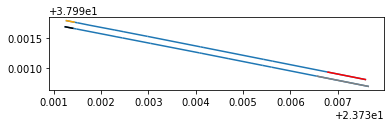

In [197]:
ax = edges[(edges.name == 'Αλεξάνδρας')].plot()
ax = downstream_start.plot(ax=ax, color='red')
ax = downstream_end.plot(ax=ax, color='orange')
ax = upstream_start.plot(ax=ax, color='black')
ax = upstream_end.plot(ax=ax, color='grey')

In [198]:
%%time
#****************************************************************
# Main mapmatching routine
#****************************************************************
# Make connectivity map
map_con = make_map(nodes, edges)
# List to store trips of interest
trips = []
# Loop through all original trajectories
for trajectory in tqdm(traj_collection.trajectories[:]):
    try:
        trip = trajectory.df.copy(deep=True).reset_index()
        route = [tuple(x) for x in trip[['lat', 'lon']].to_numpy()]
        # Run matcher
        matcher = DistanceMatcher(map_con,
                                  max_dist=300,
                                  min_prob_norm=0.0001,
                                  obs_noise=15,
                                  max_lattice_width=6,
                                  avoid_goingback=True,
                                  non_emitting_states=False)
        states, _ = matcher.match(route, tqdm=None)
        states_df = pd.DataFrame(states, columns=['u', 'v'])
        # Extract projected coordinates
        coords_list = []
        match = matcher.lattice_best
        for m in match:
            lat, lon = m.edge_m.pi[:2]
            coords_list.append((lat, lon))
        coords_df = pd.DataFrame(coords_list)
        projection = gpd.GeoDataFrame(coords_df,
                                      geometry=gpd.points_from_xy(
                                          coords_df[1],
                                          coords_df[0],
                                          crs={'init': 'epsg:4326'}))
        trip['projection'] = projection['geometry'].values
        # Match trip with the respective street
        trip['u'] = states_df.u.values
        trip['v'] = states_df.v.values
        trip = pd.merge(trip,
                        edges.reset_index(),
                        how='left',
                        left_on=['u', 'v'],
                        right_on=['u', 'v'])
        # Check if arterial is part of the trip
        trip.rename({
            'geometry_x': 'geometry',
            'geometry_y': 'linestring'
        },
                    axis=1,
                    inplace=True)  
        mask = trip.linestring.astype(str).isin(arterial.geometry.astype(str))
        if np.any(mask):
            trip = gpd.GeoDataFrame(trip[mask].reset_index(drop=True))
            # Measure calibrated distance from origin
            distances = []
            for point in trip.projection.values:
                coords = (point.y, point.x)
                d = distance.GeodesicDistance(start, coords).m
                distances.append(d * e)
            trip['distances'] = distances
            trips.append(trip)
        else:
            continue
    except Exception as ex:
        print(ex.args[0])
        continue      

  0%|          | 0/3001 [00:00<?, ?it/s]

Did not find a matching node for path point at index 3021
CPU times: user 2h 48min 57s, sys: 32.8 s, total: 2h 49min 30s
Wall time: 2h 49min 28s


***********************************

# Time-space diagram (mixed)

  0%|          | 0/1004 [00:00<?, ?it/s]

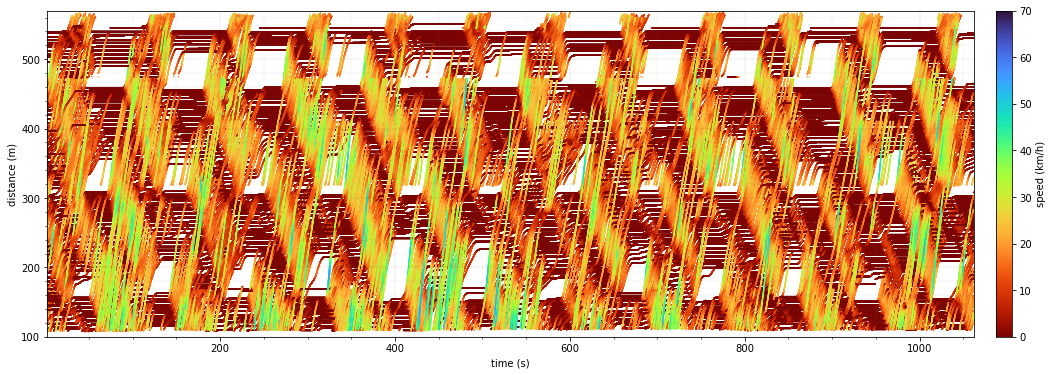

In [240]:
valid_trips = []
fig, ax = plt.subplots(figsize=(20, 6))
plt.xlim([traj_collection.get_min('time'), traj_collection.get_max('time')])
plt.ylim([100, 570])
ax.minorticks_on()
ax.grid(which='minor', linestyle='--', linewidth=0.1, color='grey')
ax.grid(which='major', linestyle='--', linewidth=0.1, color='black')
for trip in tqdm(trips):
    times = trip.time.values
    speed = trip.speed.values
    distances = trip.distances.values
    # Skip static or non-monotonic trips
    _, counts = np.unique(distances, return_counts=True)
    if (max(counts) > 4000) or (np.any(np.diff(distances) < -0.2) or
                                (len(trip) < 40)):
        continue
    valid_trips.append(trip)
    ax = plt.scatter(times,
                     distances,
                     c=speed,
                     s=2,
                     ec=None,
                     cmap='turbo_r',
                     alpha=1,
                     vmin=0,
                     vmax=70,
                     antialiased=True)
plt.ylabel('distance (m)')
plt.xlabel('time (s)')
plt.colorbar(pad=0.02, label='speed (km/h)')
#fig.savefig('speed.png', format='png', dpi=300)
plt.show()

*********************

# Serialize valid trajectories

In [241]:
valid_trajectories = []
for trip in valid_trips:
    trajectory = mpd.Trajectory(trip.set_index('timestamp'), traj_id='track_id')
    valid_trajectories.append(trajectory)

In [243]:
%%time
valid_traj_collection = mpd.TrajectoryCollection(valid_trajectories[:])
print(valid_traj_collection)

TrajectoryCollection with 972 trajectories
CPU times: user 2min 40s, sys: 192 ms, total: 2min 40s
Wall time: 2min 41s


In [12]:
# Path for trajectories
collection_dir = f"{path}collections/"
if not os.path.exists(collection_dir):
    os.makedirs(collection_dir)
collection_file = f"{collection_dir}{files[find][:-4]}.pickle"
collection_file

'./data/pNEUMA/collections/20181024_d8_0930_1000.pickle'

In [245]:
# Export trajectory collection 
with open(collection_file, 'wb') as f:
    pickle.dump(valid_traj_collection, f)

In [13]:
# Import trajectory collection
with open(collection_file, "rb") as f:
    unpickler = pickle.Unpickler(f)
    valid_traj_collection = unpickler.load()

***********************************************

# Principal Component Analysis (PCA)

In [16]:
copies = []
for trajectory in valid_traj_collection.trajectories[:]:
    copy = trajectory.df.copy(deep=True)
    copy = copy[[
        'geometry',
        'projection',
        'track_id',
        'time',
        'speed',
        'lat_acc',
        'lon_acc',
        'type',
        'distances',
    ]].reset_index(drop=True)
    copies.append(copy)

In [17]:
%%time
copies = gpd.GeoDataFrame(pd.concat(copies)).to_crs(epsg=3857)
copies['x'] = copies.geometry.x
copies['y'] = copies.geometry.y

CPU times: user 2min 6s, sys: 655 ms, total: 2min 7s
Wall time: 2min 7s


In [111]:
pca_cols = [
    'x',
    'y',
#    'lat_acc',
#    'lon_acc',
]
X = copies[pca_cols].reset_index(drop=True)
pca = PCA(n_components=len(pca_cols), random_state=0)
principalComponents = pca.fit_transform(X)
X_std = StandardScaler().fit_transform(principalComponents)

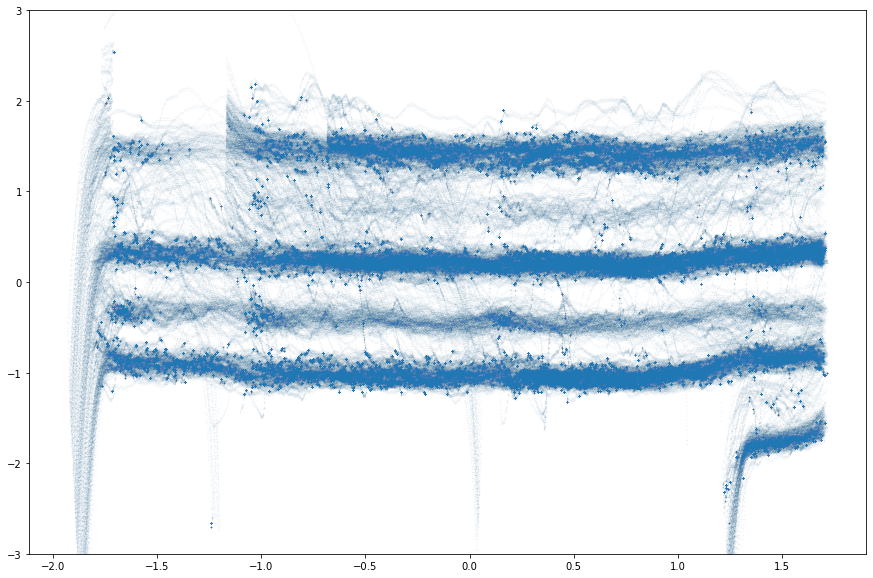

In [112]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.ylim([-3, 3])
ax = plt.scatter(-X_std[:,0], -X_std[:,1], s=2e-4)

 **********************

# Pre-indexing with Self Organizing Map (SOM)

In [113]:
# Randomly sample coordinates
size = int(1e5)
training = X_std[np.random.choice(len(X_std), size, replace=False)]

In [114]:
# Train SOM
msz11 = 160
msz10 = 160

som2 = SOM.SOM("",
               training,
               mapsize=[msz10, msz11],
               norm_method="var",
               initmethod="pca")
som2.init_map()
som2.train(n_job=8, shared_memory="no", verbose="final")

Total time elapsed: 234.902000 secodns
final quantization error: 0.008625


In [115]:
# Calculate best matching units (bmus)
bmus = som2.project_data(X_std)
copies['bmu'] = bmus

In [116]:
codebook2 = som2.codebook[:]
codebook2_n = SOM.denormalize_by(som2.data_raw,
                                 codebook2,
                                 n_method="var")

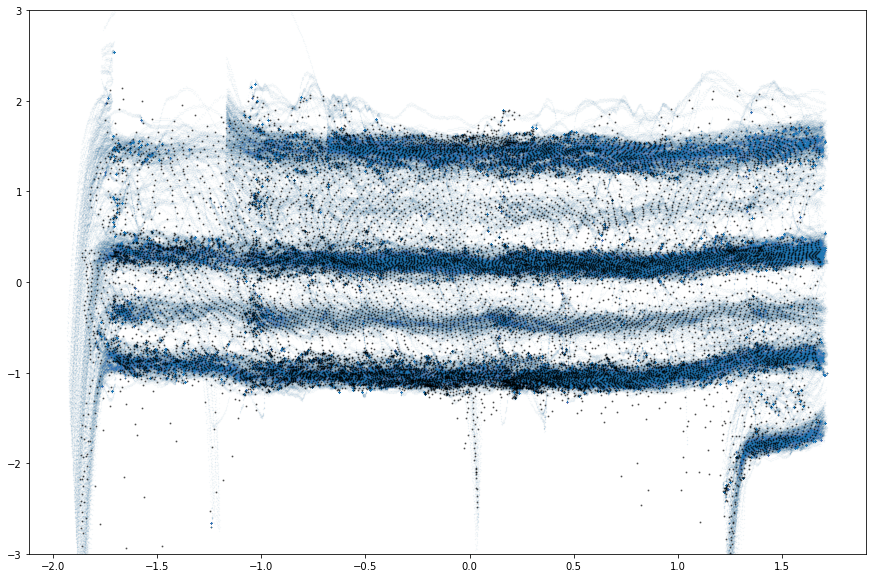

In [250]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.ylim([-3, 3])
plt.scatter(-X_std[:, 0], -X_std[:, 1], s=2e-4)
ax = plt.scatter(-codebook2_n[:, 0], -codebook2_n[:, 1], c='black', s=1, alpha=.5)

# Clustering with DBSCAN

In [118]:
active = list(set(np.unique(bmus)))

In [119]:
len(active)/len(codebook2_n)

0.9960532006920415

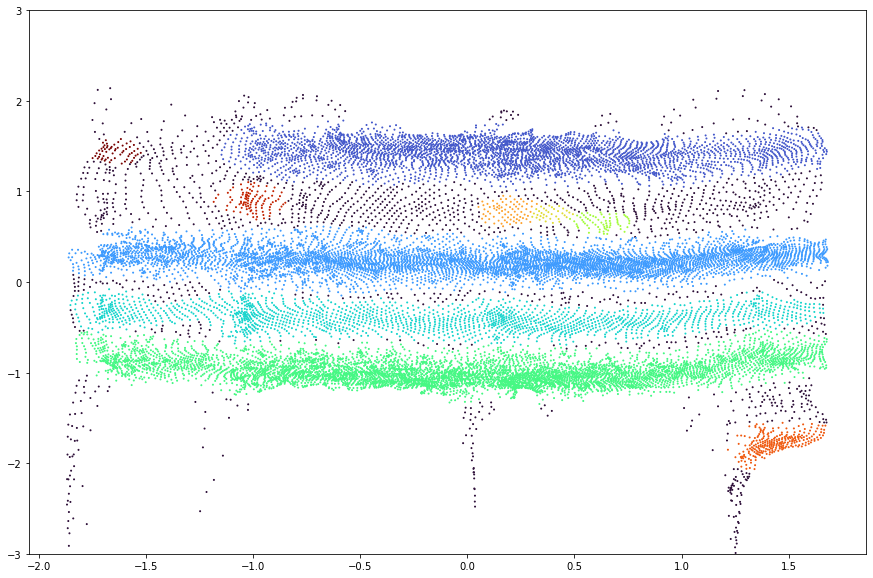

In [233]:
dbscan = DBSCAN(eps=0.1, min_samples=35, algorithm='auto', n_jobs=-1)
clusters = dbscan.fit_predict(codebook2_n[:,[0,1]])
fig, ax = plt.subplots(figsize=(15, 10))
plt.ylim([-3, 3])
ax = plt.scatter(-codebook2_n[active, 0],
                 -codebook2_n[active, 1],
                 s=1,
                 c=clusters[active],
                 cmap='turbo')

 ***************************************************************

# Lane assignment

In [234]:
result = pd.merge(copies,
                     pd.DataFrame(clusters),
                     how='left',
                     left_on=['bmu'],
                     right_index=True)
result.rename({0: 'lane'}, axis=1, inplace=True)

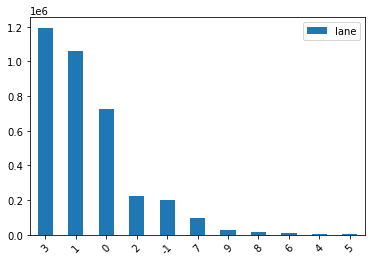

In [235]:
ax = result.lane.value_counts(dropna=False).plot.bar(rot=45, legend=True)

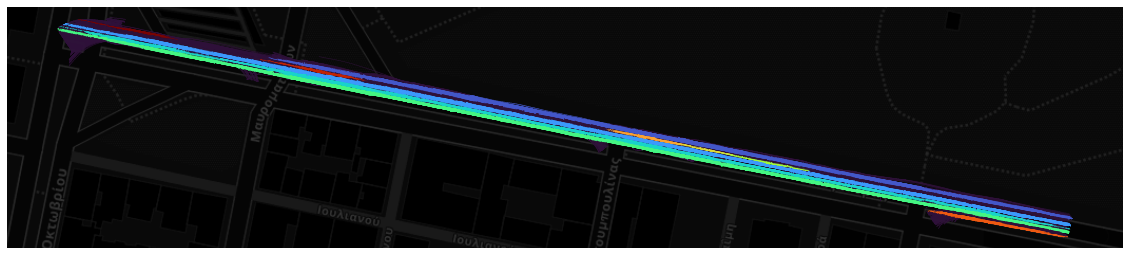

In [253]:
fig, ax = plt.subplots(figsize=(20, 20))
lat_trace = result['y']
lon_trace = result['x']
ax.scatter(lon_trace,
           lat_trace,
           s=.5,
           ec=None,
           c=result.lane.values,
           zorder=1,
           cmap='turbo')
ax.set_axis_off()
ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)

************************************************

# Time-space diagram (per lane)

In [246]:
# List of lanes
lanes = []
for i in range(4):
    lane = result[(result.lane == i)]
    lane.reset_index(drop=True, inplace=True)
    lanes.append(lane)

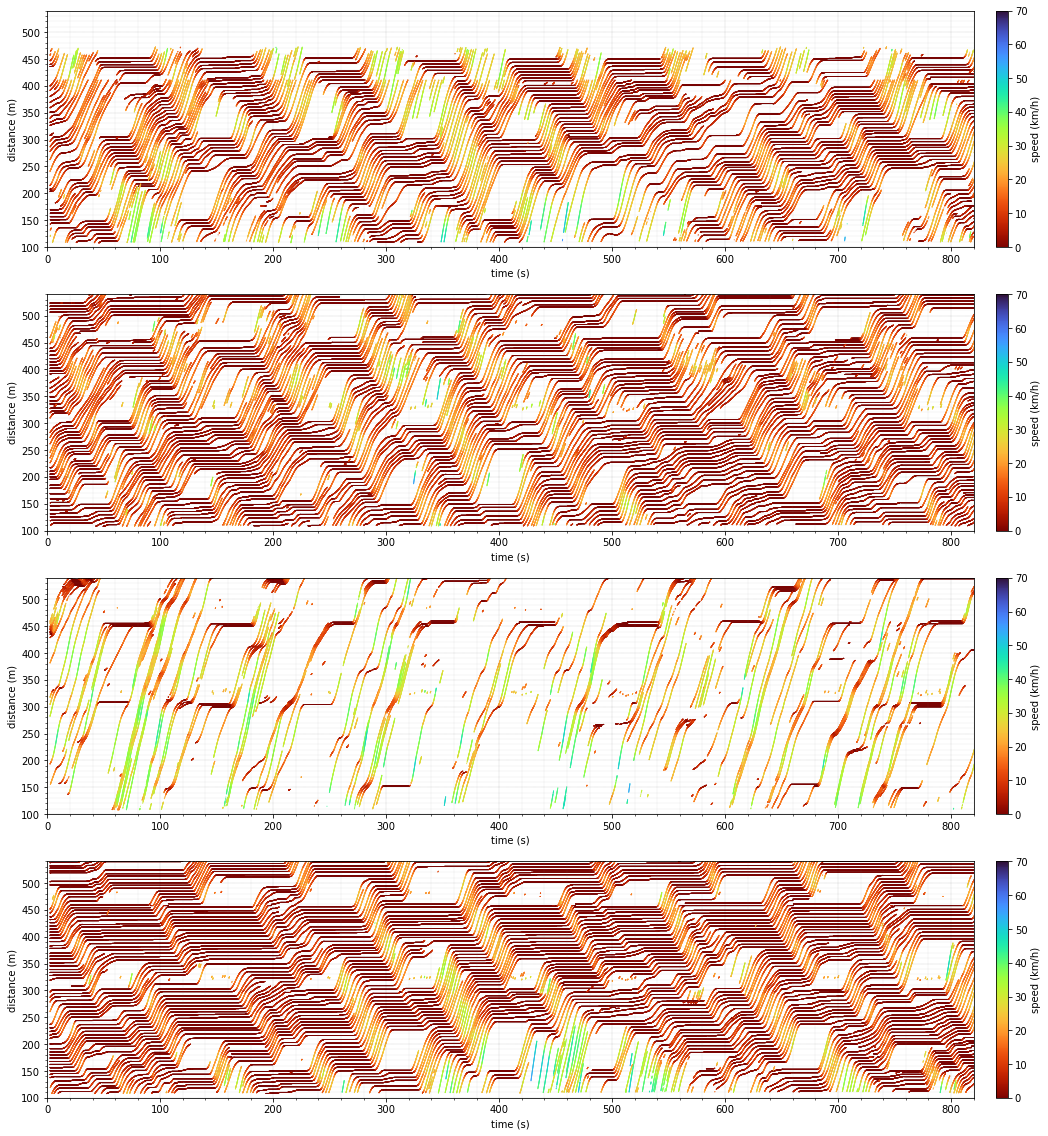

In [249]:
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

for i, lane in enumerate(lanes):
    axes[i].set_xlim([0, 820])
    axes[i].set_ylim([100, 540])
    axes[i].minorticks_on()
    axes[i].grid(which='minor', linestyle='--', linewidth=0.1, color='grey')
    axes[i].grid(which='major', linestyle='--', linewidth=0.1, color='black')

    times = lane.time.values
    speed = lane.speed.values
    distances = lane.distances.values
    pcm = axes[i].scatter(times,
                          distances,
                          c=speed,
                          s=1,
                          ec=None,
                          cmap='turbo_r',
                          alpha=1,
                          vmin=0,
                          vmax=70,
                          antialiased=True)
    axes[i].set_xlabel('time (s)')
    axes[i].set_ylabel('distance (m)')
    fig.colorbar(pcm, ax=axes[i], pad=0.02, label='speed (km/h)')
#fig.savefig('speed.png', format='png', dpi=300)